In [1]:
!cp -r '/content/drive/MyDrive/Images_in_jpg_color' 'train_data'
!cp -r '/content/drive/MyDrive/test_set' 'validation_data'

In [15]:
from keras.preprocessing.image import ImageDataGenerator
datagenerator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')
train_generator = datagenerator.flow_from_directory('/content/train_data', target_size=(32, 32), class_mode='categorical')
validation_generator = datagenerator.flow_from_directory('/content/validation_data', target_size=(32, 32), class_mode='categorical')

Found 39209 images belonging to 43 classes.
Found 12633 images belonging to 43 classes.


In [16]:
import csv
import cv2 as cv
import numpy
from keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.initializers import glorot_uniform
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [17]:
model = VGG16(include_top=False, input_shape=(32, 32, 3))
for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(80, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1')(flat1)
output = Dense(43, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [20]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, batch_size=1000)

Epoch 1/10
  17/1226 [..............................] - ETA: 4:28:11 - loss: 20.9215 - accuracy: 0.0298

KeyboardInterrupt: ignored

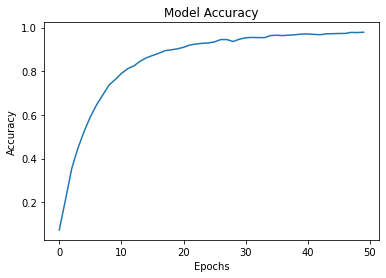

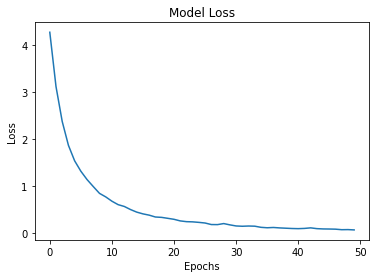

In [ ]:
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(model.history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
cnn_model.save('/content/drive/MyDrive/tsr_model_v1.h5')

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(y_pred.shape)
print(classification_report(Y_test, y_pred))

(12630, 43)


ValueError: ignored